## 0. Setting up the Environment


In [1]:
## impoort labaries 
import os 
import cv2
import mat73
import time
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage.transform import resize
from keras.models import Sequential
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D

## 1. Data Importing 

In [2]:
## Combain the df with the Pitutary & Meningioma types with the dataframe of the Glioma grades (I, II,, IV).
img_size = 256
df = pd.read_pickle(r"../../Datasets/Dataset_B_resized_256.pkl")
df.sample(5)

,PID,Label,Image,File
2975,106284,Meningioma,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",293.mat
336,HF1345,Glioma II,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
2056,108550,Meningioma,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",112.mat
199,HF1235,Glioma II,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
2422,112552,Meningioma,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",145.mat


C:\Users\Ma7moud\anaconda3\envs\UNet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Label', ylabel='count'>

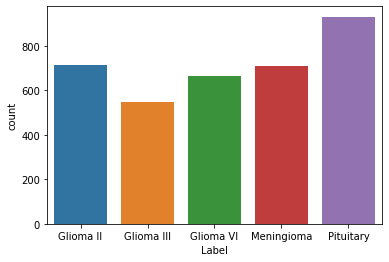

In [4]:
sns.countplot(df.Label)

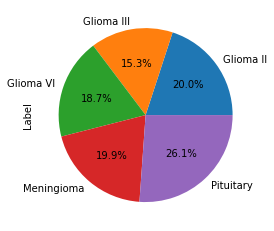

In [5]:
data = df.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

## 2. Data-Preprocessing 

 2.1 Image Resizing 


In [25]:
# ## Image Resizing from (512, 512) pixals to (128, 128)
# resized_df  =  df.copy()
# new_shape = 256

# def imgResize(img):
#     return resize(img,(new_shape,new_shape))

# resized_df['Image'] = resized_df['Image'].apply(imgResize)

In [26]:
# ## This code block displays a random MR Image Befor and After Resizing 


# randInt = np.random.randint(0,len(df))
# # create figure
# fig = plt.figure(figsize=(10, 7))
  
# # setting values to rows and column variables
# rows = 1
# columns = 2

# label = df.Label[randInt]
  
# # Display a Random Image before resizing
# fig.add_subplot(rows, columns, 1)
# plt.imshow(df.Image[randInt],cmap='gray')
# plt.title('{}\nOriginal Image Shape: {}'.format(label, df.Image[randInt].shape))
# plt.axis('off')
  
# # Display a Random Image after resizing
# fig.add_subplot(rows, columns, 2)
# plt.imshow(resized_df.Image[randInt],cmap='gray')
# plt.title('{}\nResized Image Shape: {}'.format(label, resized_df.Image[randInt].shape))
# plt.axis('off')
  

2.2 Data Agumentation

In [28]:
# 2.3 Grayscale to RGB
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')
df.Image = df.Image.apply(normalize)

In [29]:
len(df)

3559

In [30]:
# ## select a radom image from the dataframe
# randInt = np.random.randint(0,len(df.File.unique()))
# random_img = df[df.File == str(randInt) + '.mat'].reset_index(drop=True, inplace=False)

# ## plot the same image with it's differenet agumentations. 
# plt.figure(figsize=(23, 15))
# for i in range(len(random_img)):
#   plt.subplot(1,5, i+1)
#   plt.imshow(random_img.Image[i], cmap='gray')
#   plt.title(random_img['Argumentation type'][i])
#   plt.axis('off')
# plt.show()


2.3 Splitting Data into Train, Test, and Validation Sets

In [32]:
## Splitting Images form Labels
y = df["Label"]

X = df['Image'].tolist()
## Adding extra Color channel to the grayscale images
X = np.array(X).reshape(-1, img_size, img_size, 3)

print(f"shape of Images: {X.shape}, shape of the labels {y.shape}")

shape of Images: (3559, 256, 256, 3), shape of the labels (3559,)


In [33]:
## Splitting Data to : 75% Train set, 15% Test set, and 10% Validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size=0.40, random_state=42)

In [34]:
# saving a copy of the testing labels before one hot encoding
y_test_eval = y_test
# one hot endcoding the labels 
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_val   = pd.get_dummies(y_val)

print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_test shape :",X_test.shape,"| y_test shape : ", y_test.shape)
print("X_val shape  : ",X_val.shape,"| y_val shape  : ", y_val.shape)
print("\nTotal Data: ", len(df))

X_train shape: (2669, 256, 256, 3) | y_train shape: (2669, 5)
X_test shape : (534, 256, 256, 3) | y_test shape :  (534, 5)
X_val shape  :  (356, 256, 256, 3) | y_val shape  :  (356, 5)

Total Data:  3559


In [35]:
y_test

,Glioma II,Glioma III,Glioma VI,Meningioma,Pituitary
2917,0,0,0,1,0
3026,0,0,0,1,0
776,0,1,0,0,0
2383,0,0,0,0,1
1498,0,0,1,0,0
...,...,...,...,...,...
3250,0,0,0,1,0
1271,0,0,1,0,0
535,1,0,0,0,0
2114,0,0,0,0,1


In [36]:
## This Dictionary is used to decode the model's predicted values.  
decode_dict = {0 : "Grade II", 1 : "Grade III", 2 : "Grade VI", 3: "Meningioma", 4: "Pituitary"}

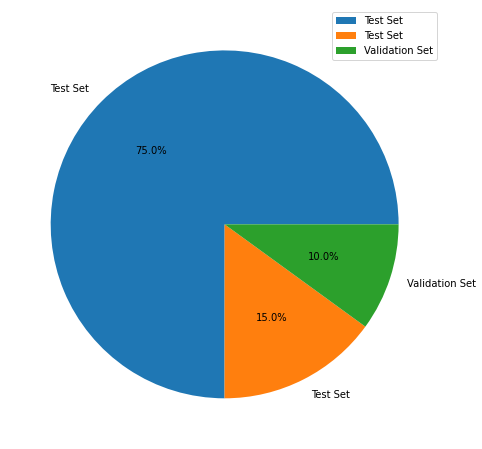

In [37]:
import matplotlib.pyplot as plt
import numpy as np
##  Creating a Pie chart illustrating the percentage of the train, validation, test sets.
Data = np.array([len(y_train), len(y_test), len(y_val)])
mylabels = ["Test Set", "Test Set", "Validation Set"]
plt.figure(figsize=(13, 8))
plt.pie(Data, labels = mylabels, autopct="%.1f%%", )
plt.legend()
plt.show() 

##3. Models Creation


In [42]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D, Input, Lambda
import tensorflow as tf
import time
from tensorflow.keras import optimizers
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from glob import glob




vgg16 = VGG16(include_top=False, weights=None, input_shape = (img_size, img_size, 3))

for layer in vgg16.layers:
    layer.trainable = False

# Dense Lyers
x = Flatten()(vgg16.output)
outLayers = Dense(5, activation='softmax')(x)

m1 = Model(inputs = vgg16.input, outputs = outLayers)

m1.summary()
m1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

##4. Model Training


In [43]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 5 )

m1.fit(X_train,y_train,epochs=100, validation_data=(X_val,y_val), callbacks = [early_stop], verbose=1)

Epoch 1/100
84/84 [==============================] - 16s 115ms/step - loss: 1.2519 - accuracy: 0.5212 - val_loss: 1.0215 - val_accuracy: 0.5590
Epoch 2/100
84/84 [==============================] - 7s 82ms/step - loss: 0.8504 - accuracy: 0.6684 - val_loss: 0.9273 - val_accuracy: 0.6039
Epoch 3/100
84/84 [==============================] - 7s 83ms/step - loss: 0.6792 - accuracy: 0.7508 - val_loss: 0.7592 - val_accuracy: 0.7219
Epoch 4/100
84/84 [==============================] - 7s 83ms/step - loss: 0.5960 - accuracy: 0.7947 - val_loss: 0.7045 - val_accuracy: 0.7584
Epoch 5/100
84/84 [==============================] - 7s 83ms/step - loss: 0.5160 - accuracy: 0.8393 - val_loss: 0.6477 - val_accuracy: 0.7781
Epoch 6/100
84/84 [==============================] - 7s 83ms/step - loss: 0.4458 - accuracy: 0.8606 - val_loss: 0.6334 - val_accuracy: 0.7584
Epoch 7/100
84/84 [==============================] - 7s 83ms/step - loss: 0.4280 - accuracy: 0.8651 - val_loss: 0.7184 - val_accuracy: 0.7107
Epoc

In [44]:
# Get training history
metrics = pd.DataFrame(m1.history.history)

In [45]:
# Evaluate the model's accuarcy 
m1.evaluate(X_test, y_test)

17/17 [==============================] - 4s 246ms/step - loss: 0.2746 - accuracy: 0.9120


[0.2745960056781769, 0.9119850397109985]

In [54]:
import os

if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
exp_num = []
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))

if len(exp_num) == 0:
    exp_path = r"./experiments/exp"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)

os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [55]:
print(results)

./experiments/exp\results


In [57]:
# Save The Trained model along with it training history   
Accuracy = m1.evaluate(X_test, y_test)[-1]
name = str(round(Accuracy, 4))

metrics.to_pickle(os.path.join(results, name+'.pkl'))
m1.save(os.path.join(weights, name + '.h5'))

17/17 [==============================] - 1s 77ms/step - loss: 0.2746 - accuracy: 0.9120


In [ ]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Lossy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
## Get the 
predict_x = m1.predict(X_test) 
predictions = np.argmax(predict_x,axis=1) 

In [ ]:
# Decode the Model's predections  (from [0,1,0,2..] to ['Glioma','Meningioma'...]) of the Test set using the the dictionary 'decode_dict' 
predictions = np.vectorize(decode_dict.get)(predictions)

In [ ]:
print(classification_report(y_test_eval, predictions))

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test_eval, predictions))
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap="PuBu",fmt = 'd')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')